In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'quote-of-genius:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5596569%2F9250777%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240901%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240901T123306Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dcb97efac42721682f7fb73c23ccee54c072e4f14b3e950cca25adddb8fd2268b0f8cfb17bcc18aebcda3aad6585a7ecf85b358ecb06f46b6f1d9b4bd91481378b6d5f069293fbbbf0908b99727f94d374c59a7f13fdd20103be198031447e8d613282ab76d40e10f5c96ded501dd04c807de22530e6e35166fc6ae56b686ae34e90f4e19232443ca9dd9cbc01635e3e06463a665d44baf2408bb3bd435bbfe3a68fb9cb74c56a1d6ba67141dd6a24ca913ac9eb6ffe790654603a7e284b2c5045da75c93c8de2dc5cdf10c3a2f43f0dbb47358d8b61963f16c6165b635437dc056b06a9906cf5181b0bf79cd6c4401159befab6e66bf5791f51958c9d7d3d40a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 211995 bytes downloaded
Downloaded and uncompressed: quote-of-genius
Data source import complete.


# Importing the libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN , LSTM,Flatten,Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
df = pd.read_csv('/kaggle/input/quote-of-genius/qoute_dataset.csv')

In [4]:
df.head()

,quote,Author
0,“The world as we have created it is a process ...,Albert Einstein
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling
2,“There are only two ways to live your life. On...,Albert Einstein
3,"“The person, be it gentleman or lady, who has ...",Jane Austen
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe


In [5]:
sentences = df['quote']
sentences.head()

,quote
0,“The world as we have created it is a process ...
1,"“It is our choices, Harry, that show what we t..."
2,“There are only two ways to live your life. On...
3,"“The person, be it gentleman or lady, who has ..."
4,"“Imperfection is beauty, madness is genius and..."


# Removing the punctuation

In [6]:
punctuation=string.punctuation

#Function to remove punctuation form text

def remove_punctuation(text):
  return text.translate(str.maketrans('','',punctuation))

#Apply remove_punctuation function to 'Text' column

sentences = sentences.apply(remove_punctuation)

sentences.head()

,quote
0,“The world as we have created it is a process ...
1,“It is our choices Harry that show what we tru...
2,“There are only two ways to live your life One...
3,“The person be it gentleman or lady who has no...
4,“Imperfection is beauty madness is genius and ...


# Tokenize the data

In [7]:
#intialinzing the tokenizer

tokenizer = Tokenizer()

#Fitting the tokenizer on the sentences
tokenizer.fit_on_texts(sentences)

#Getting  the number of unique words(plus one for padding)
total_words = len(tokenizer.word_index)+1

#Creating empty list to  hold imput sequences
input_sequences = []

#Loopipng through the sentences and Creating input sequences

for  line in sentences:
  #Tokenizer the current line
  token_list = tokenizer.texts_to_sequences([line])[0]


  #Looping through the token and Creating n-grams
  for i in range(1, len(token_list)):
    #creating n-gram sequence
    n_gram_sequence = token_list[:i+1]

    #Appending the n-gram sequences to the Input sequences list
    input_sequences.append(n_gram_sequence)


# Creating  the padded sequnces

In [8]:
#Finding the maximum length of the  input sequences
max_sequence_len = max([len(x) for x in input_sequences])

#paddind the input sequences
input_sequences = pad_sequences(input_sequences, maxlen = max_sequence_len, padding ='pre')

#printing the padded input sequences and the maximum sequence length

print('padded input sequences  :', input_sequences , '\n')
print('Max Sequence Len :', max_sequence_len)

padded input sequences  : [[   0    0    0 ...    0  713   62]
 [   0    0    0 ...  713   62   29]
 [   0    0    0 ...   62   29   19]
 ...
 [   0    0    0 ...   19 1125    3]
 [   0    0    0 ... 1125    3  169]
 [   0    0    0 ...    3  169  101]] 

Max Sequence Len : 746


# Splitting input sequneces into X and Y

In [9]:
#Splitting the input sequences into X and Y data

X= input_sequences[:,:-1]
Y =input_sequences[:,-1]


#one hot Encoding the y

In [10]:
y = keras.utils.to_categorical(Y,num_classes=total_words)

# Creating th Sequential Model

In [11]:
#Model Building RNN

#Creating a ssequential model

model = Sequential()
model.add(Embedding(total_words, 100 , input_length = max_sequence_len-1))
model.add(LSTM(100))
model.add(Dense(total_words, activation= 'softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Model Compilation

In [12]:
#compilling the model
model.compile(loss= 'categorical_crossentropy',optimizer = 'adam',metrics =["accuracy"])


# Model trianing

In [13]:
historty = model.fit(X,y, epochs = 10 , batch_size = 128 , verbose = 1)

Epoch 1/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 43s 56ms/step - accuracy: 0.0363 - loss: 7.0626
Epoch 2/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.0587 - loss: 6.3258
Epoch 3/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.0882 - loss: 6.0125
Epoch 4/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step - accuracy: 0.1076 - loss: 5.7688
Epoch 5/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.1224 - loss: 5.5404
Epoch 6/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.1342 - loss: 5.3542
Epoch 7/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step - accuracy: 0.1428 - loss: 5.1983
Epoch 8/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.1525 - loss: 5.0480
Epoch 9/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.1611 - loss: 4.9004
Epoch 10/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.1703 - loss: 4.7737


Plotting the grap

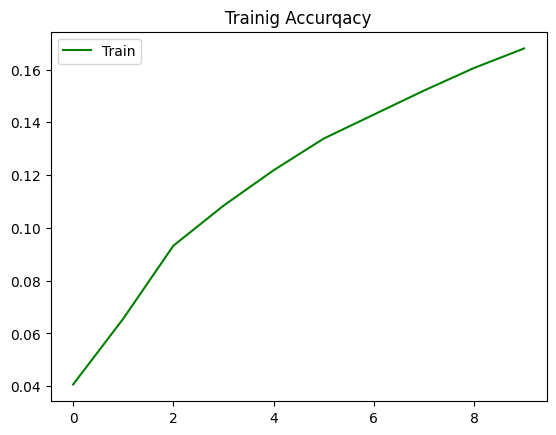

In [16]:
plt.title('Trainig Accurqacy')

plt.plot(historty.history['accuracy'],color = 'Green', label = 'Train')

plt.legend()

# Prediction

In [20]:
# Function to predict the next word in a given seed text
def predict_next_word(seed_text, next_words=1):

  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    predicted = model.predict(token_list, verbose=0)

    predicted_word_index = np.argmax(predicted, axis=-1)[0]

    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted_word_index:
        output_word = word
        break
    seed_text += " " + output_word
  return seed_text


In [21]:
print(f"Real Quote : {sentences[0]}")

Real Quote : “The world as we have created it is a process of our thinking It cannot be changed without changing our thinking”


In [22]:
print(f"Predicted Quotes after 3 words as input : \n{predict_next_word('the world as',18)}")

Predicted Quotes after 3 words as input : 
the world as a book is a man who is a man who was a man who was a man who
